#Customer churn

Customers began to leave the bank. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

It is necessary to predict whether the client will leave the bank in the near future or not. We have historical data on customer behavior and termination of contracts with the bank.

The task is to build a model with an extremely large *F1*-metric. The target metric value is not lower than 0.59.

It is also necessary to additionally measure *AUC-ROC* and compare its value with the *F1*.

## Data preparation

### Prepare the libraries necessary for the work

In [2]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

### Let's study the data inside the dataframe and do the necessary preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')
csv_path = '/content/drive/My Drive/projects/bank_customer_churn_classification/churn.csv'
# Read the CSV file into a Pandas DataFrame
data = pd.read_csv(csv_path)
pd.set_option('display.max_columns', None)
display(data.shape);
display(data.head());
display(data.info());

Mounted at /content/drive


(10000, 14)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

**Features:**
- RowNumber — row index in the data
- CustomerId — unique client identifier
- Surname - surname
- CreditScore - credit rating
- Geography - country of residence
- Gender - gender
- Age - age
- Tenure - how many years a person has been a bank client
- Balance - account balance
- NumOfProducts — number of bank products used by the client
- HasCrCard - availability of a credit card
- IsActiveMember — client activity
- EstimatedSalary - estimated salary

**Target feature:**
- Exited—the fact that the client has left

In [ ]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**We see that the values of various features are very different from each other in absolute terms, accordingly, we will need to further scale them.**

**Let’s check below the values of various signs for adequacy and compliance with the logic embedded in them.**

In [ ]:
data['HasCrCard'].unique()

array([1, 0])

In [ ]:
data['IsActiveMember'].unique()

array([1, 0])

In [ ]:
data['Exited'].unique()

array([1, 0])

**We see that the values of the signs `'HasCrCard'`, `'IsActiveMember'`, `'Exited'` coincide with the logic embedded in them.**

**Let's see how the values of the `'EstimatedSalary'` attribute are distributed.**

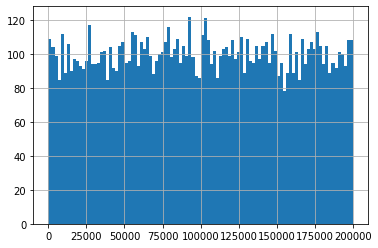

In [ ]:
data['EstimatedSalary'].hist(bins=100);

**We can conclude that the data cut from the general database was made in such a way that clients with different levels of expected salary were equally represented.**

**You may notice that we have only 3 features (`'Surname'`, `'Geography'`, `'Gender'`) with a non-numeric data type that will have to be subsequently converted using the OHE (One-Hot Encoding) technique for training models machine learning.**

**You can also see gaps in the `'Tenure'` attribute. It is unknown how strongly a given trait is related to the target one. Let's check it out.**

In [ ]:
data_no_na = data.dropna()
display(data_no_na['Tenure'].isna().sum())
data_no_na.corrwith(data_no_na['Tenure'])

0

RowNumber         -0.007322
CustomerId        -0.021418
CreditScore       -0.000062
Age               -0.013134
Tenure             1.000000
Balance           -0.007911
NumOfProducts      0.011979
HasCrCard          0.027232
IsActiveMember    -0.032178
EstimatedSalary    0.010520
Exited            -0.016761
dtype: float64

**There is no strong correlation between the `'Tenure'` feature and other numerical features.**

**Let's check what percentage of the total amount of data is missing in the `'Tenure'` attribute.**

In [ ]:
data['Tenure'].isna().sum()/data.shape[0]

0.0909

**9 percent is less than the limit value of 10%, but let's try to save this data by filling in the gaps in the `'Tenure'` attribute. You can, of course, fill in the gaps by training the model on other features and making `'Tenure'` the target feature, but let's do it more simply - fill in the gaps in the `'Tenure'` feature with the median value.**

In [4]:
df = data.fillna(data['Tenure'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Let's evaluate the unique values of the `'Tenure'` attribute.**

In [ ]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

**We see that all values are integer, let’s change the type to integer.**

In [5]:
df['Tenure'] = df['Tenure'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Let's look at the data in the `'Surname'` attribute. Let's find out how often certain surnames appear in the dataframe, and whether there are any specifics there.**

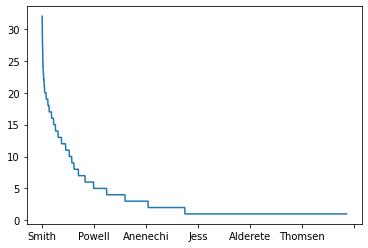

In [ ]:
df['Surname'].value_counts().plot();

**We see that there is no non-standard distribution or “skew” of data in the surnames, everything is quite standard. The last name refers to a person’s ID and, in general, should not affect his behavior and, accordingly, the likelihood of leaving the bank.**

**Let's see how many unique surnames the data contains.**

In [ ]:
df['Surname'].nunique()

2932

** Because We decided that the surname in general should not affect the probability of leaving the bank and the number of unique surnames is 2932, then for better and faster training of our models it would be logical to remove this feature, otherwise when using the OHE technique we will receive an additional 2931 columns , which will additionally overload our dataset and increase the running time of the algorithms.**

**At the same time, the signs `'RowNumber'` - the row index in the data and `'CustomerId'` - the unique identifier of the client also cannot in any way influence the likelihood of the client leaving, we will remove these signs as well.**

In [6]:
df = df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


**Let's check the remaining non-numeric attributes for duplicates and implicit duplicates.**

In [ ]:
display(df['Gender'].value_counts())
df['Geography'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

**We see that there are no duplicates and the unique values are adequate.**

**Now, using the OHE method, we will prepare the data.**

In [7]:
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


**Let’s check how balanced the classes of the target feature are in our data.**

In [ ]:
data_ohe['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

**We see that the ratio of classes is almost 1 to 4, there is an imbalance of classes. First, let's look at the quality of the models without eliminating the class imbalance, and then we'll look at the quality of the models after eliminating the class imbalance.**

**In the case of our task, the target attribute (which needs to be predicted) is `'Exited'`, it means whether the customer will leave. The values of this feature can be either 0 or 1, respectively, in this case we are faced with the task of binary classification.**

** Because Since we do not have a “hidden” test sample, the data must be divided into three parts: training, validation and test samples. Let's choose equal sizes of test and validation sets.**

**Accordingly, we will divide the initial data in the ratio 3 : 1 : 1, i.e. 0.6 : 0.2 : 0.2**

**The `'train_test_split'` function only divides the dataset into two parts, so to get 3 randomly generated samples of the required relative size, we apply this function twice.**

**Next, we will divide each of the three parts into two parts - features and target feature.**

In [8]:
data_part, data_valid = train_test_split(data_ohe, test_size=0.2, random_state=1)
data_train, data_test = train_test_split(data_part, test_size=0.25, random_state=1)

display(data_train.shape)
display(data_valid.shape)
data_test.shape

(6000, 12)

(2000, 12)

(2000, 12)

In [9]:
features_train = data_train.drop('Exited', axis=1)
target_train = data_train['Exited']

features_valid = data_valid.drop('Exited', axis=1)
target_valid = data_valid['Exited']

features_test = data_test.drop('Exited', axis=1)
target_test = data_test['Exited']


display(features_train.shape, target_train.shape)
display(features_valid.shape, target_valid.shape)
display(features_test.shape, target_test.shape)

(6000, 11)

(6000,)

(2000, 11)

(2000,)

(2000, 11)

(2000,)

**The data contains features with a large absolute difference in the spread of values. As you know, the algorithm automatically decides that a feature with larger values is more important, but this is not true: all features are significant. To eliminate this, we scale the features using data standardization.**

**For this we will use a separate structure for data standardization - StandardScaler from the sklearn.preprocessing module.**

In [10]:
features_train_scaled = features_train.copy()
features_valid_scaled = features_valid.copy()
features_test_scaled = features_test.copy()

pd.options.mode.chained_assignment = None
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train_scaled[numeric] = scaler.transform(features_train_scaled[numeric])
features_valid_scaled[numeric] = scaler.transform(features_valid_scaled[numeric])
features_test_scaled[numeric] = scaler.transform(features_test_scaled[numeric])

display(features_train_scaled.head())
display(features_valid_scaled.head())
display(features_test_scaled.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4495,1.427934,-0.656100,0.722340,-0.113714,-0.905397,1,0,0.134255,0,0,0
6470,-0.705851,0.198238,-0.006621,0.018224,-0.905397,1,0,1.572963,1,0,0
2221,1.200054,-0.371320,0.357859,0.894255,-0.905397,1,0,0.274208,1,0,0
7686,0.692503,0.862723,1.451301,-1.227467,0.805051,1,1,-0.479772,0,0,1
9419,0.361041,-1.225658,-1.464544,-0.306243,-0.905397,1,1,-0.356880,1,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9953,-1.047671,0.767796,-1.100063,-1.227467,0.805051,1,1,-0.046900,0,0,1
3850,0.298892,-0.466247,-0.735583,1.071364,-0.905397,1,0,-0.576570,0,0,1
4962,-1.244477,0.293164,-1.100063,-1.227467,0.805051,0,1,-0.160008,0,0,0
3886,0.609638,-0.466247,1.086821,1.144204,0.805051,0,1,-1.703601,1,0,1
5437,-1.120179,-0.845952,0.357859,-0.048620,-0.905397,1,1,1.334650,1,0,1


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7857,2.059783,-1.130732,0.357859,0.323152,0.805051,0,0,0.919111,0,0,1
9924,-0.198300,1.052576,-0.006621,0.504512,-0.905397,1,1,-1.609508,1,0,0
3087,-2.197429,-0.276394,-1.100063,1.428211,0.805051,1,1,0.419765,0,0,1
3513,1.438292,-0.561173,1.815782,0.940258,-0.905397,0,0,1.655810,0,0,0
2105,-1.648446,-0.751026,0.722340,-1.227467,0.805051,1,1,-0.872579,0,0,0


**Data prepared. Let's move on to research.**

## Problem research

**We will use the Random Forest model.**

**The most important hyperparameters of the random forest classification algorithm: 'max_depth' - depth, 'n_estimators' - number of trees in the forest. Let's determine at what values of 'max_depth' and 'n_estimators' we will get the best quality of this model on the validation set and determine the value of this quality itself.**

**First, we will choose the optimal depth for a small number of trees, and then we will increase the number of trees.**

In [15]:
best_model_random_forest = None
best_f1_random_forest = 0
best_depth_random_forest = 0

for depth in range (1, 20):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=20, max_depth=depth, criterion='entropy')
    model_random_forest.fit(features_train_scaled, target_train)
    predicted_valid = model_random_forest.predict(features_valid_scaled)


    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:

        best_model_random_forest = model_random_forest


        best_f1_random_forest = f1_random_forest
        best_depth_random_forest = depth
print(f'The best result of Random Forest Model:\n max_depth = {best_depth_random_forest}\n f1 = {best_f1_random_forest}')

The best result of Random Forest Model:
 max_depth = 12
 f1 = 0.5929339477726575


**Now we will increase the number of trees in the forest.**

In [16]:
best_model_random_forest = None
best_f1_random_forest = 0
best_est_random_forest = 0

for est in range (1, 50, 1):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=12, criterion='entropy')
    model_random_forest.fit(features_train_scaled, target_train)
    predicted_valid = model_random_forest.predict(features_valid_scaled)


    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:

        best_model_random_forest = model_random_forest


        best_f1_random_forest = f1_random_forest
        best_est_random_forest = est
print(f'The best result of Random Forest Model:\n est = {best_est_random_forest}\n f1 = {best_f1_random_forest}')

The best result of Random Forest Model:
 est = 17
 f1 = 0.6021505376344086


**Let’s check what AUC-ROC value for this model with the specified hyperparameter values we will get on the validation set. Remember that a value of 0.5 corresponds to a random model.**

In [ ]:
probabilities_valid = best_model_random_forest.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8662582189958572

**On the validation set, the AUC-ROC value was significantly higher than that of the random model.**

**Intermediate output:**

**We obtained the best f1-measure result above 0.59 for the validation sample, which satisfies the original task. This result was obtained for "Random Forest" with the following parameters:**
- criterion = 'entropy'
- n_estimators = 17
- max_depth = 12

**For the same trained model on the validation set, the AUC-ROC value was significantly higher than that of the random model.**

## Imbalance correction

**There are two ways to eliminate class imbalance - by increasing the class that is in decline, or vice versa - by decreasing the class that is in excess.**

**Let's try the 1st scenario - increasing the class that is in drawdown. To do this, let's write a function.**

In [13]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=1)

    return features_upsampled, target_upsampled

one_count = features_train_scaled[target_train == 1].shape[0]
zero_count = features_train_scaled[target_train == 0].shape[0]
mult_coef = round(zero_count/one_count)
features_upsampled, target_upsampled = upsample(features_train_scaled, target_train, mult_coef)

display(features_upsampled.shape)
display(target_upsampled.shape)


features_upsampled[target_upsampled == 1].shape[0] / features_upsampled[target_upsampled == 0].shape[0]

(9621, 11)

(9621,)

1.007302315877321

In [14]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1)

    return features_downsampled, target_downsampled

one_count = features_train_scaled[target_train == 1].shape[0]
zero_count = features_train_scaled[target_train == 0].shape[0]
div_coef = one_count/zero_count

features_downsampled, target_downsampled = downsample(features_train_scaled, target_train, div_coef)

display(features_downsampled.shape)
display(target_downsampled.shape)


features_downsampled[target_downsampled == 1].shape[0] / features_downsampled[target_downsampled == 0].shape[0]

(2414, 11)

(2414,)

1.0

**Let’s once again search for hyperparameters of the “Random Forest” model that give the best f1-measure result on new balanced training samples.**

**First, we will choose the optimal depth for a small number of trees, and then we will increase the number of trees.**

**Let's start with an expanded sample.**

In [17]:
best_model_random_forest = None
best_f1_random_forest = 0
best_depth_random_forest = 0

for depth in range (1, 20):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=20, max_depth=depth, criterion='entropy')
    model_random_forest.fit(features_upsampled, target_upsampled)
    predicted_valid = model_random_forest.predict(features_valid_scaled)


    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:

        best_model_random_forest = model_random_forest


        best_f1_random_forest = f1_random_forest
        best_depth_random_forest = depth
print(f'The best result of the "Random Forest" model:\n max_depth = {best_depth_random_forest}\n f1 = {best_f1_random_forest}')

The best result of the "Random Forest" model:
 max_depth = 10
 f1 = 0.6297117516629712


**Теперь будем увеличивать кол-во деревьев в лесу.**

In [18]:
best_model_random_forest = None
best_f1_random_forest = 0
best_est_random_forest = 0

for est in range (1, 50, 1):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=10, criterion='entropy')
    model_random_forest.fit(features_upsampled, target_upsampled)
    predicted_valid = model_random_forest.predict(features_valid_scaled)


    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:

        best_model_random_forest = model_random_forest


        best_f1_random_forest = f1_random_forest
        best_est_random_forest = est
print(f'The best result of the "Random Forest" model:\n est = {best_est_random_forest}\n f1 = {best_f1_random_forest}')

The best result of the "Random Forest" model:
 est = 23
 f1 = 0.6320441988950276


**Now we’ll do the same thing, but for a narrowed-down sample.**

In [19]:
best_model_random_forest = None
best_f1_random_forest = 0
best_depth_random_forest = 0

for depth in range (1, 20):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=20, max_depth=depth, criterion='entropy')
    model_random_forest.fit(features_downsampled, target_downsampled)
    predicted_valid = model_random_forest.predict(features_valid_scaled)


    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:

        best_model_random_forest = model_random_forest


        best_f1_random_forest = f1_random_forest
        best_depth_random_forest = depth
print(f'The best result of the "Random Forest" model:\n max_depth = {best_depth_random_forest}\n f1 = {best_f1_random_forest}')

The best result of the "Random Forest" model:
 max_depth = 8
 f1 = 0.6069364161849712


In [20]:
best_model_random_forest = None
best_f1_random_forest = 0
best_est_random_forest = 0

for est in range (1, 50, 1):
    model_random_forest = RandomForestClassifier(random_state=1, n_estimators=est, max_depth=8, criterion='entropy')
    model_random_forest.fit(features_downsampled, target_downsampled)
    predicted_valid = model_random_forest.predict(features_valid_scaled)


    f1_random_forest = f1_score(target_valid, predicted_valid)
    if f1_score(target_valid, predicted_valid) > best_f1_random_forest:

        best_model_random_forest = model_random_forest


        best_f1_random_forest = f1_random_forest
        best_est_random_forest = est
print(f'The best result of the "Random Forest" model:\n est = {best_est_random_forest}\n f1 = {best_f1_random_forest}')

The best result of the "Random Forest" model:
 est = 45
 f1 = 0.6147859922178988


**We see that firstly, the value of the f1-measure criterion has increased compared to training using a sample with unbalanced classes. Secondly, balancing by expanding the sample gave better results, which is logical, because in this case there was more data.**

**The best results of f1-measure = 0.632 were obtained for the validation sample, which satisfies the original task. This result was obtained for “Random Forest” using an extended balanced sample with the following parameters:**
- criterion = 'entropy'
- n_estimators = 23
- max_depth = 10

**Let’s check what AUC-ROC value we get for this model with the specified hyperparameter values. Remember that a value of 0.5 corresponds to a random model.**

In [21]:
model_random_forest = RandomForestClassifier(random_state=1, n_estimators=23, max_depth=10, criterion='entropy')
model_random_forest.fit(features_upsampled, target_upsampled)
probabilities_valid = model_random_forest.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.8636889513891528

**On the validation set, the AUC-ROC value was significantly higher than that of the random model.**

**Let's test our model with the selected hyperparameters on the test sample.**

In [ ]:
model_random_forest = RandomForestClassifier(random_state=1, n_estimators=51, max_depth=7)
model_random_forest.fit(features_upsampled, target_upsampled)
predicted_test = model_random_forest.predict(features_test_scaled)
f1_random_forest = f1_score(target_valid, predicted_test)
f1_random_forest

0.5977249224405378

**We have obtained an f1-measure value that satisfies the conditions of the problem, the goal has been achieved.**

**Let's check what AUC-ROC (area under the ROC curve) value we get for this model. Remember that a value of 0.5 corresponds to a random model.**

In [ ]:
roc_auc_score(target_test, predicted_test)

0.6790923948158566

**The AUC-ROC value is higher than 0.5 of the random model, which further characterizes our result in a positive way.**

## Model testing

**Let's test our model with the selected hyperparameters on the test sample.**

In [22]:
model_random_forest = RandomForestClassifier(random_state=1, n_estimators=23, max_depth=10, criterion='entropy')
model_random_forest.fit(features_upsampled, target_upsampled)

predicted_test = model_random_forest.predict(features_test_scaled)


f1_random_forest = f1_score(target_test, predicted_test)
print('f1_test =',f1_random_forest)

probabilities_test = model_random_forest.predict_proba(features_test_scaled)
probabilities_one_test = probabilities_test[:, 1]
print('ROC_AUC_test =',roc_auc_score(target_test, probabilities_one_test))

f1_test = 0.5980707395498392
ROC_AUC_test = 0.8326281783284557


**So, on the test sample, the trained model performed satisfactorily, achieving a metric value of f1-measure = 0.598, which is higher than the 0.59 stated in the task, and the value of the ROC-AUC metric was 0.833, which also significantly exceeds the results typical for a random model.**

**Conclusions.**

**The “Random Forest” model with hyperparameters proved to be the best for solving the problem**

- criterion = 'entropy'
- n_estimators = 23
- max_depth = 10

**Trained on a balanced augmented sample whose data was pre-scaled using standardization and pre-trained.**

**Class balancing brought an improvement in f1-measure.**